# Model Evaluation: F1 and ROC

## Use “Telecom churn” data.
Job simulation exercise: I am working as a marketing analyst for a large telecom company. The head of marketing wants to know why customers are churning and prepare a plan to reduce customer churn. I am provided with company data and my task is to explore the data and find some insights that will help the marketing head to better strategize the marketing campaign for the next year.
- Current bill amount of each customer (Current Bill Amt)
- Average calls made by each customer (Avg Calls)
- Average calls made by the customers during the weekdays (Avg Calls Weekdays)
- How long the account has been active (Account Age)
- Average number of days the customer has defaulted on bill payment (Avg Days Delinquent)
- Customer complaints (Complaint Code)
- Change in monthly bill amount (Percent Increase MOM)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Report the average values of the following variables by Churn vs. No-churn.
- cur_bill_amt, avg_call, avg_call_wkday, acct_age, avg_day_delinquent

In [2]:
# Read data

df= pd.read_csv('Telecom churn.csv')
df.head()

,churn,cur_bill_amt,avg_call,avg_call_wkday,acct_age,avg_day_delinquent,percent_MOM,complain_code,acct_plan,tech_sup_complain,day_open_workorder,equipment_age,condition_handset,avg_hour_workorder_open
0,no_churn,14210,17950.00000,30297.000,24,6.2,-0.334193,Billing Problem,Gold,0,0.0,8,1,0.0
1,churn,14407,0.00000,0.000,28,1.0,0.000000,Moving,Silver,0,0.0,17,1,0.0
2,churn,12712,204.66667,10393.667,23,17.6,0.000000,Billing Problem,Gold,0,0.0,23,1,0.0
3,no_churn,13807,15490.33300,41256.332,39,0.0,0.148986,Billing Problem,Silver,0,0.0,17,1,0.0
4,no_churn,3805,5075.00000,12333.333,23,3.8,-0.686046,Billing Problem,Gold,0,0.0,10,1,0.0


- `df = pd.read_csv('Telco churn.csv')` reads data from a CSV file named "Telco churn.csv" and loads it into a pandas DataFrame.

In [3]:
# Calculate average by 'churn'

df.groupby('churn').mean()

,cur_bill_amt,avg_call,avg_call_wkday,acct_age,avg_day_delinquent,percent_MOM,tech_sup_complain,day_open_workorder,equipment_age,condition_handset,avg_hour_workorder_open
churn,,,,,,,,,,,
churn,20184.792326,9410.960514,37865.139659,25.591367,19.209832,-0.265381,0.464748,2.741007,12.255156,1.018225,0.921242
no_churn,19700.729282,9372.022723,39687.363130,27.052486,9.122744,0.284556,0.379374,2.655157,11.635359,1.020258,0.931732


- `df.groupby('churn').mean()` is using the groupby method to group the data in the DataFrame df by the 'churn' column, which is expected to be a categorical variable indicating whether a customer has churned (left the service) or not. After grouping, it calculates the mean (average) of the numerical columns for each group

### 2. Create dummy variables from churn, acct_plan, and complain_code.

In [4]:
# Idenfify the number of categories in each variable

pd.crosstab(df.acct_plan, df.complain_code)  # to confirm the categories of each variable

complain_code,Billing Problem,Call Quality,Check Account,Inaccurate Sales Inf,Moving,Pricing
acct_plan,,,,,,
Gold,446,194,28,2,65,3
Silver,2195,762,149,10,402,1


- `pd.crosstab(df.acct_plan, df.complain_code)`: This line calculates the cross-tabulation between 'acct_plan' and 'complain_code'. The resulting table will display the frequency of each combination of 'acct_plan' and 'complain_code'.

In [5]:
# Create dummies

df['churn']=(df.churn=='churn').astype(int)
df['plan_gold']=(df.acct_plan=='Gold').astype(int)
complain_dum = pd.get_dummies(df.complain_code)  # 6 dummies

df=pd.concat([complain_dum, df], axis=1)  # Combine complain_dum with df
df.head()

# df=pd.get_dummies(df, drop_first=True)
 # Alternative: create dummies from all string variables and drop first category of each variable

,Billing Problem,Call Quality,Check Account,Inaccurate Sales Inf,Moving,Pricing,churn,cur_bill_amt,avg_call,avg_call_wkday,...,avg_day_delinquent,percent_MOM,complain_code,acct_plan,tech_sup_complain,day_open_workorder,equipment_age,condition_handset,avg_hour_workorder_open,plan_gold
0,1,0,0,0,0,0,0,14210,17950.00000,30297.000,...,6.2,-0.334193,Billing Problem,Gold,0,0.0,8,1,0.0,1
1,0,0,0,0,1,0,1,14407,0.00000,0.000,...,1.0,0.000000,Moving,Silver,0,0.0,17,1,0.0,0
2,1,0,0,0,0,0,1,12712,204.66667,10393.667,...,17.6,0.000000,Billing Problem,Gold,0,0.0,23,1,0.0,1
3,1,0,0,0,0,0,0,13807,15490.33300,41256.332,...,0.0,0.148986,Billing Problem,Silver,0,0.0,17,1,0.0,0
4,1,0,0,0,0,0,0,3805,5075.00000,12333.333,...,3.8,-0.686046,Billing Problem,Gold,0,0.0,10,1,0.0,1


- `df['churn'] = (df.churn == 'churn').astype(int)`: Converts the 'churn' column to a binary integer variable.
    - If the value in the 'churn' column is equal to the string 'churn,' it is converted to 1, and if it's not equal to 'churn,' it is converted to 0.
    - `astype(int)` converts the data type to integers (from a boolean column with True and False).
- `complain_dum = pd.get_dummies(df.complain_code)`: This code creates dummy variables for the 'complain_code'.
- `df = pd.concat([complain_dum, df], axis=1)`: Combines the dummy variables (complain_dum) with the original DataFrame df.

In [6]:
# Display all columns

pd.set_option('display.max_columns', None)  # None(No limit) or value
df.head()

,Billing Problem,Call Quality,Check Account,Inaccurate Sales Inf,Moving,Pricing,churn,cur_bill_amt,avg_call,avg_call_wkday,acct_age,avg_day_delinquent,percent_MOM,complain_code,acct_plan,tech_sup_complain,day_open_workorder,equipment_age,condition_handset,avg_hour_workorder_open,plan_gold
0,1,0,0,0,0,0,0,14210,17950.00000,30297.000,24,6.2,-0.334193,Billing Problem,Gold,0,0.0,8,1,0.0,1
1,0,0,0,0,1,0,1,14407,0.00000,0.000,28,1.0,0.000000,Moving,Silver,0,0.0,17,1,0.0,0
2,1,0,0,0,0,0,1,12712,204.66667,10393.667,23,17.6,0.000000,Billing Problem,Gold,0,0.0,23,1,0.0,1
3,1,0,0,0,0,0,0,13807,15490.33300,41256.332,39,0.0,0.148986,Billing Problem,Silver,0,0.0,17,1,0.0,0
4,1,0,0,0,0,0,0,3805,5075.00000,12333.333,23,3.8,-0.686046,Billing Problem,Gold,0,0.0,10,1,0.0,1


- `pd.set_option('display.max_columns', None)` sets a display option in pandas to show all columns when displaying a DataFrame. By setting the maximum number of displayed columns to "None," you ensure that pandas will display all columns in the DataFrame.

### 3. Divide the data into 75% training and 25% test set (use random_state=10) and run the following logistic regression model on training data. Report coefficients including intercept.
- churn = β0 + β1 avg_day_delinquent + β2 percent_MOM + β3 avg_call_wkday + β4 cur_bill_amt + β5 avg_call + β6 complain_code(as dummies) + β7 acct_age + ε

In [7]:
# Define y, x

y=df.churn
x=df[['avg_day_delinquent', 'percent_MOM', 'avg_call_wkday',
      'cur_bill_amt', 'avg_call', 'acct_age',
      'Call Quality', 'Check Account', 'Inaccurate Sales Inf', 'Moving', 'Pricing']]
 # Billing Problem: omitted category of complaint_code

- `x = df[[...]]`: x is a DataFrame that includes a set of independent variables or features.

In [8]:
# Divide x into training and test sets. Run logistic regression and obtain coefficients.

xtrain, xtest, ytrain, ytest=train_test_split(x, y, random_state=10)
m = LogisticRegression(random_state=10).fit(xtrain, ytrain)
m.coef_

array([[ 1.22482496e-01, -9.14828400e-03, -4.33692206e-06,
         1.70576634e-06,  4.89538113e-06, -5.92496660e-02,
         4.22761145e-03, -1.06695274e-03,  9.62899546e-06,
        -2.64671283e-03,  4.29331990e-06]])

- `train_test_split(x, y, random_state=10)`: This function is used to split your dataset into training and testing sets for machine learning.
- `m = LogisticRegression(random_state=10).fit(xtrain, ytrain)`: This code creates a logistic regression model (m) and fits it to the training data.
- `m.coef_`: This line retrieves the coefficients of the logistic regression model.

### 4. Report model accuracy, confusion matrix, precision, recall, and F1 score on test data.

In [9]:
# Predict y and obtain scores

pred = m.predict(xtest)
m.score(xtest, ytest)  # accuracy
print('Accuracy', metrics.accuracy_score(ytest, pred))
print('Precision', metrics.precision_score(ytest, pred))  # TP/P*
print('Recall', metrics.recall_score(ytest, pred))  # TP/P
print('F1 Score', metrics.f1_score(ytest, pred))

Accuracy 0.7183098591549296
Precision 0.7304526748971193
Recall 0.6774809160305344
F1 Score 0.7029702970297029


- `pred = m.predict(xtest)`: Make predictions using the model m on the test data xtest, and the predictions are stored in the variable pred.
- `m.score(xtest, ytest)`: Calculates the accuracy of the model m on the test data. It computes the fraction of correctly classified instances. The xtest contains the input features, and ytest contains the true labels.
- `metrics.accuracy_score(ytest, pred)`: Calculates the accuracy of the model using accuracy_score function. It compares the true labels ytest with the predicted labels pred and prints the accuracy.
- `metrics.precision_score(ytest, pred)`: Calculates the precision of the model. Precision is a measure of how many of the positively predicted instances were actually positive.
- `metrics.recall_score(ytest, pred)`: Calculates the recall of the model. Recall is a measure of how many of the actual positive instances were correctly predicted as positive.
- `metrics.f1_score(ytest, pred)`: Calculates the F1 score of the model. The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both.

In [10]:
# Obtain classification report

print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       541
           1       0.73      0.68      0.70       524

    accuracy                           0.72      1065
   macro avg       0.72      0.72      0.72      1065
weighted avg       0.72      0.72      0.72      1065



- `classification_report` function calculates several metrics, including precision, recall, F1-score, and support for each class.

In [11]:
# Obtain confusion matrix

metrics.confusion_matrix(ytest, pred) 

array([[410, 131],
       [169, 355]], dtype=int64)

- `metrics.confusion_matrix(ytest, pred)` calculates the confusion matrix for a classification model's predictions. The confusion matrix is a table that summarizes the performance of a classification algorithm by counting the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

|             | Predicted 0 (P*) | Predicted 1 (N*) |
|-------------|:----------------:|-----------------:|
| Actual 0 (N)|        TN        |        FP        |
| Actual 1 (P)|        FN        |        TP        |

### 5. Draw ROC curve with AUC on test data.

In [12]:
# Predict probabilities on test data

prob = m.predict_proba(xtest)
prob  # column 1,2: prob of negative and positive class

array([[0.41807412, 0.58192588],
       [0.56472977, 0.43527023],
       [0.69473617, 0.30526383],
       ...,
       [0.72182918, 0.27817082],
       [0.81850493, 0.18149507],
       [0.70998987, 0.29001013]])

- `prob = m.predict_proba(xtest)` Used to obtain the predicted probabilities for each class for the instances in the test dataset.
    - `m` is trained classification model.
    - `xtest` is the test dataset containing input features for which you want to make predictions.
    - `predict_proba` returns a matrix or array where each row corresponds to an instance in the xtest dataset, and each column corresponds to a class label.

In [13]:
# Obtain predictions for positive class, fpr, tpr, decisin threshold, AUC

prob = m.predict_proba(xtest)[:, 1]  # all rows, 2nd column
fpr, tpr, threshold = roc_curve(ytest, prob)
 # roc_curve takes observed labels and predicted prob, then returns fpr,tpr,thresholds for each tpr&fpr

roc_auc = auc(fpr, tpr)
print('Out-Sample AUC: %0.4f' % roc_auc)  # '%0.4f' %: display 4 digit after decimal

Out-Sample AUC: 0.7823


- `prob = m.predict_proba(xtest)[:, 1]`: Extracts the predicted probabilities for the positive class (class 1) from the predict_proba output.
- `fpr, tpr, threshold = roc_curve(ytest, prob)`: Calculates the False Positive Rate (FPR), True Positive Rate (TPR), and the threshold values for various cutoff points.
- `roc_auc = auc(fpr, tpr)`: Calculates the Area Under the ROC Curve (AUC). The AUC is a single scalar value that represents the overall performance of the binary classification model.
- `print('Out-Sample AUC: %0.4f' % roc_auc)`: This line prints the AUC with four decimal places.
    - '%0.4f' % displays the AUC value with four digits after the decimal point.

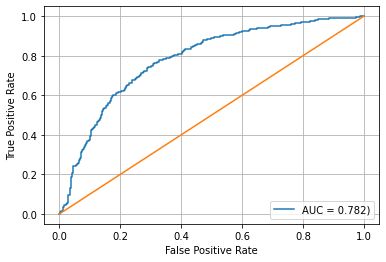

In [14]:
# Disply ROC curve

plt.plot(fpr, tpr, label='AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1]) # straight line
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.figure(figsize=(10,7)) # enlarge size
# plt.title('ROC Curve')

- `plt.plot(fpr, tpr, label='AUC = %0.3f)' % roc_auc)`: Creates a plot of the ROC curve using fpr (False Positive Rate) on the x-axis and tpr (True Positive Rate) on the y-axis.
- `plt.plot([0, 1], [0, 1])`: Adds a straight line to the plot. The straight line represents the ROC curve of a random classifier (no discrimination power), which serves as a reference line.
- `plt.grid()`: This line adds a grid to the plot, making it easier to read and interpret the graph.
- `plt.xlabel('False Positive Rate')`: This line labels the x-axis as "False Positive Rate."
- `plt.ylabel('True Positive Rate')`: This line labels the y-axis as "True Positive Rate."
- `plt.legend(loc="lower right")`: This line adds a legend to the plot, and it specifies that the legend should appear in the lower right corner of the plot.

### 6. What is the optimal decision threshold (probability) that maximizes (TPR-FPR)?

In [15]:
# Obtain the optimal decision threshold 

best_thresh = threshold[np.argmax(tpr-fpr)]
 # np.argmax returns the index of the maximum value
best_thresh

0.4545694877159777

- `np.argmax(tpr - fpr)` calculates the index of the threshold where the difference between TPR and FPR is maximized.
- `threshold[np.argmax(tpr - fpr)]` retrieves the threshold value corresponding to the index found in the previous step.

In [16]:
print(max(tpr-fpr))  # maximum of (TPR-FPR)
np.argmax(tpr-fpr)  # Index of maximum of (TPR-FPR)

0.4540714819884014


213

### 7. Report model accuracy, confusion matrix, precision, recall, and F1 score on test data using the optimal threshold. Discuss differences in results based on the two thresholds (default and optimal).

In [17]:
# Predict y using the optimal threshold and obtain scores

pred1 = (prob >= best_thresh).astype('int')  # convert Boolean to integer
print('Accuracy',  metrics.accuracy_score(ytest, pred1))
print('Precision', metrics.precision_score(ytest, pred1))
print('Recall',    metrics.recall_score(ytest, pred1))
print('F1 Score',  metrics.f1_score(ytest, pred1))

Accuracy 0.7267605633802817
Precision 0.7129798903107861
Recall 0.7442748091603053
F1 Score 0.7282913165266106


- `pred1 = (prob >= best_thresh).astype('int')` is creating binary class predictions based on the calculated threshold value best_thresh.
    - `(prob >= best_thresh)` creates a Boolean array that compares each element of prob to best_thresh. If the probability is greater than or equal to the threshold, it evaluates to True, indicating a positive prediction. If it's below the threshold, it evaluates to False, indicating a negative prediction.
    - `astype('int')` converts the Boolean values to integers, where True becomes 1 and False becomes 0. 

In [18]:
# Obtain confusion matrix

metrics.confusion_matrix(ytest, pred1)

array([[384, 157],
       [134, 390]], dtype=int64)

Text(0.5, 15.0, 'Predicted')

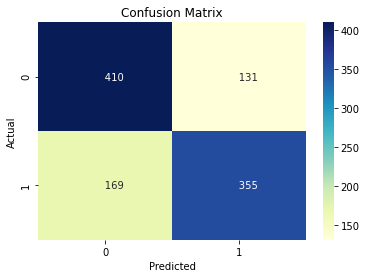

In [19]:
# Confusion matrix heatmap

sns.heatmap(pd.DataFrame(metrics.confusion_matrix(ytest, pred)), annot=True, cmap="YlGnBu", fmt='9.0f')
 # annot: number in cell, cmap: color, fmt=9.0f: no decimal point
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

- `sns.heatmap(pd.DataFrame(metrics.confusion_matrix(ytest, pred)), annot=True, cmap="YlGnBu", fmt='9.0f')`: Creates a heatmap using seaborn. It takes the confusion matrix calculated by metrics.confusion_matrix(ytest, pred), converts it into a Pandas DataFrame, and then uses sns.heatmap to display it as a color-coded matrix.
    - `annot=True` specifies that the numerical values should be displayed in each cell.
    - `cmap="YlGnBu"` sets the color map to yellow-green-blue.
    - `fmt='9.0f'` formats the numbers with no decimal points.
- `plt.title('Confusion Matrix')`: Sets the title of the heatmap plot to "Confusion Matrix."
- `plt.ylabel('Actual')`: Labels the y-axis with "Actual".
- `plt.xlabel('Predicted')`: Labels the x-axis with "Predicted".